# Import Library and Requirement Listing

### Import Library

In [1]:
import torch
import torch.nn as nn # Neural Network 
from torch.nn import functional as F # Torch Deep Learning Model
import mmap
import random

### Requirement Listing

In [2]:
with open('requirements.txt','w') as file:
    import sys
    import matplotlib as mpl
    import numpy as np
    import pylzma
    import ipykernel
    import jupyter
    import torch
    
    file.write(f"""
            #python{sys.version}
            # Using Virtual environment
            matplotlib=={mpl.__version__}
            numpy=={np.__version__}
            pylzma=={pylzma.__version__}
            ipykernel=={ipykernel.__version__}
            jupyter
            torch=={torch.__version__}
            """)
    

# Metadata

In [3]:
%%time
block_size = 10 # Length of file that be
batch_size = 5 # How many those model run on pararel
epochs = 2
max_iters = 10000
learning_rate = 3e-4
eval_interval = 100
eval_iters = 250 # How many iteration those model to evaluate
dropout = 0.2 # Create dropout metadata that drop neuron on deep learning pytorch so ther's no overfit
n_embd = 384 # Create length of generated section each values
n_layer = 4 # Create layer for gpt decoder because gpt-model need 4 decoder. N Layer = number of decoder block
dropout = 0.2 # Dropout 20% of Neural Network to prevent overfitting
n_head = 4 # Create Number of head that will be used in MultiHeadAttention

CPU times: total: 0 ns
Wall time: 0 ns


### See Device

In [4]:
# See the device
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# Data Loading

In [5]:
chars = ""
with open('vocab.txt','r',encoding='utf-8') as f:
    text =  f.read()
    # Get Unique Character from 2000 last index
    chars = sorted(list(set(text)))

print(chars)
# Get Vocab_Size
vocab_size = len(chars)
print(len(chars))

['\x00', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x7f', '\x80', '\x81', '\x82', '\x83', '\x84', '\x86', '\x87', '\x88', '\x89', '\x8a', '\x8b', '\x8c', '\x8d', '\x8e', '\x8f', '\x90', '\x91', '\x92', '\x93', '\x94', '\x95', '\x96', '\x97', '\x98', '\x99', '\x9a', '\x9b', '\x9c', '\x9d', '\x9e', '\x9f', '¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Í', 'Î', 'Ï', 'Ð', 'Ñ', 'Ò', 

### Create Tokenizers by Words

In [6]:
strtoint = {ch:i for i,ch in enumerate(chars)} # Encoding Purpose
inttostr = {i:ch for i,ch in enumerate(chars)} # Decoding Purpose

print(f"strtoint:{strtoint}")
print(f"inttostr:{inttostr}")

strtoint:{'\x00': 0, '\n': 1, ' ': 2, '!': 3, '"': 4, '#': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, '*': 12, '+': 13, ',': 14, '-': 15, '.': 16, '/': 17, '0': 18, '1': 19, '2': 20, '3': 21, '4': 22, '5': 23, '6': 24, '7': 25, '8': 26, '9': 27, ':': 28, ';': 29, '<': 30, '=': 31, '>': 32, '?': 33, '@': 34, 'A': 35, 'B': 36, 'C': 37, 'D': 38, 'E': 39, 'F': 40, 'G': 41, 'H': 42, 'I': 43, 'J': 44, 'K': 45, 'L': 46, 'M': 47, 'N': 48, 'O': 49, 'P': 50, 'Q': 51, 'R': 52, 'S': 53, 'T': 54, 'U': 55, 'V': 56, 'W': 57, 'X': 58, 'Y': 59, 'Z': 60, '[': 61, '\\': 62, ']': 63, '^': 64, '_': 65, '`': 66, 'a': 67, 'b': 68, 'c': 69, 'd': 70, 'e': 71, 'f': 72, 'g': 73, 'h': 74, 'i': 75, 'j': 76, 'k': 77, 'l': 78, 'm': 79, 'n': 80, 'o': 81, 'p': 82, 'q': 83, 'r': 84, 's': 85, 't': 86, 'u': 87, 'v': 88, 'w': 89, 'x': 90, 'y': 91, 'z': 92, '{': 93, '|': 94, '}': 95, '~': 96, '\x7f': 97, '\x80': 98, '\x81': 99, '\x82': 100, '\x83': 101, '\x84': 102, '\x86': 103, '\x87': 104, '\x88': 105, '\x89': 

### Create Encoder and Decoder

In [7]:
encode = lambda x:[strtoint[c] for c in x]# Tranform data to string
decode = lambda y: ''.join([inttostr[c] for c in y])# Convert array to string to decode

In [8]:
# Use wizard_of_ox.txt instead
# test = text[:200]
# len(encode(test))

In [9]:
# print(torch.tensor(encode(text),dtype=torch.long)[:100])

### Train Validation Definition

#### Loading Data

In [10]:
def get_random_chunk(split):
    # Get file type
    file = 'output_train.txt' if split.lower() == 'train' else 'output_val.txt'
    
    # Read byte with mmap and then decode it
    # mmap read only part of data to avoid reading entire things because reading like that will consume much RAM
    with open(file, 'rb') as f:
        with mmap.mmap(f.fileno(),0,access=mmap.ACCESS_READ) as mm:
            # Set Length of file size and random position 
            file_size = len(mm)
            start_pos = random.randint(0, (file_size)-block_size*batch_size)
            
            # Seek to random position and read block of text
            mm.seek(start_pos)
            block = mm.read(block_size*batch_size-1)
            
            # Decode the block to a string, ignoring any invalid data and remove '\r' from string
            decoded_block = block.decode('utf-8',errors='ignore').replace('\r','')
            
            # Train and test split
            data = torch.tensor(encode(decoded_block),dtype=torch.long)
    
    return data

### Split to Feature and Target

Overview:

BigGram Model are predicting next words based on previous words, so the feature are previous words and target are next words after previous words.

In [11]:
# Function
def get_batch(split='validation'):
    # Get Data
    data = get_random_chunk(split)
    # Generate Index
    rng_index = torch.randint(len(data) - block_size, (batch_size,))
    # print(rng_index)
    # Get Feature and Target
    x = torch.stack([data[i:i+block_size] for i in rng_index])# Get data from iteration to iteration + block size
    y = torch.stack([data[i+1:i+block_size+1] for i in rng_index])# Get data from iteration to iteration + block size
    # Use Device
    x = x.to(device)
    y = y.to(device)
    
    return x,y

In [12]:
# Get Train Validation feature and Target
X_train, y_train = get_batch('train')
X_val, y_val = get_batch('val')

In [13]:
# for i in range(block_size):
#     context = data[:i+1]
#     target = data[i]
#     print(f'when input is {context} target is {target}')

# Create GPT Language

## Overview

Certainly! The Transformer concept is a key innovation in natural language processing (NLP) that has been widely adopted in models like GPT (Generative Pre-trained Transformer). Let's break down the Transformer concept in an easy-to-digest manner:

### 1. **Motivation for Transformers:**
- Traditional sequence-to-sequence models, like RNNs and LSTMs, struggle with long-range dependencies in sequences. These models process input data sequentially, making it challenging to capture relationships between distant words in a sentence.

### 2. **Self-Attention Mechanism:**
- Transformers introduce a self-attention mechanism, allowing each word in a sequence to focus on different parts of the input sequence. This enables the model to consider all words simultaneously, addressing the issue of capturing long-range dependencies.

### 3. **Key Components:**
#### a. **Self-Attention Layer:**
   - Each word attends to every other word, and the attention scores determine how much focus each word places on others.

#### b. **Multi-Head Attention:**
   - The self-attention mechanism is applied multiple times in parallel, each with different learned weights. This allows the model to capture various aspects of the input.

#### c. **Positional Encoding:**
   - Since transformers do not inherently understand the order of words in a sequence, positional encoding is added to the input embeddings to give the model information about the positions of words.

#### d. **Feedforward Neural Network:**
   - After attention layers, the model employs feedforward neural networks to capture complex patterns and relationships within the attended information.

#### e. **Layer Normalization and Residual Connections:**
   - Each sub-layer in a transformer block is followed by layer normalization and connected via a residual connection. This helps stabilize training.

### 4. **Encoder-Decoder Architecture:**
- Transformers are often used in a sequence-to-sequence manner. In models like GPT, only the decoder part is used for tasks like language modeling, where the model generates the next word in a sequence based on context.

### 5. **GPT (Generative Pre-trained Transformer):**
- GPT is a specific implementation of the Transformer architecture for pre-training on vast amounts of text data. The model learns the statistical properties of the language and can later be fine-tuned for specific tasks like text completion or translation.

### 6. **Training and Fine-Tuning:**
- During pre-training, GPT learns to predict the next word in a sentence given the context. Fine-tuning is then performed on task-specific datasets to adapt the model for specific applications.

### 7. **Advantages:**
- Transformers have significantly improved the state-of-the-art in NLP due to their ability to capture long-range dependencies, parallel processing, and scalability.

### 8. **Applications:**
- Besides language modeling, transformers are used in various NLP tasks like text classification, translation, summarization, and question-answering.

In essence, the Transformer concept, with its self-attention mechanism and layer-wise architecture, has revolutionized the field of NLP, enabling the development of powerful language models like GPT that excel in understanding and generating human-like text.

## Processing Overview

Certainly! Let's dive into the process of a Transformer model in depth, breaking down its components and steps in an easy-to-digest manner:

### 1. **Input Representation:**
- The input to a Transformer is a sequence of tokenized words. Each word is embedded into a high-dimensional vector. Additionally, positional encoding is added to the word embeddings to provide information about the order or position of words in the sequence.

### 2. **Encoder:**
- The encoder processes the input sequence. It consists of multiple identical layers, each containing two main components:
  - **Self-Attention Mechanism:**
    - Each word attends to every other word in the sequence, and attention scores determine the importance of each word to the others.
  - **Feedforward Neural Network:**
    - After attention, the information is passed through a feedforward neural network to capture complex patterns.

### 3. **Multi-Head Attention:**
- The self-attention mechanism is applied multiple times in parallel, each with different learned weights. This allows the model to capture different aspects of the input sequence.

### 4. **Position-wise Feedforward Networks:**
- After the multi-head attention, the output goes through a position-wise feedforward network. This step allows the model to capture intricate patterns and relationships within the attended information.

### 5. **Normalization and Residual Connections:**
- After each sub-layer (self-attention and feedforward), layer normalization is applied, and the output is connected via a residual connection. This helps stabilize training.

### 6. **Decoder:**
- The decoder is similar to the encoder but has an additional layer for cross-attention. Like the encoder, it contains multiple identical layers with self-attention and feedforward components. The cross-attention allows the model to focus on different parts of the input sequence.

### 7. **Masked Self-Attention:**
- During training, the self-attention mechanism in the decoder uses a mask to prevent attending to future positions in the sequence. This ensures that each word can only attend to previous words, preserving the autoregressive property.

### 8. **Final Linear and Softmax Layer:**
- The output of the decoder is transformed into probabilities over the vocabulary using a linear layer followed by a softmax activation. During training, the model is optimized to minimize the negative log likelihood of the target sequence.

### 9. **Training Process:**
- The model is pre-trained on a large corpus using unsupervised learning, often predicting the next word in a sequence. After pre-training, it can be fine-tuned for specific tasks using labeled datasets.

### 10. **Inference Process:**
- During inference, the model generates sequences autoregressively. Given an initial input, it predicts the next word, and the predicted word is then fed back into the model as input for the next prediction. This process continues until an end token is generated or a maximum sequence length is reached.

### 11. **Advantages of Transformers:**
- Transformers excel at capturing long-range dependencies, allow parallel processing, and are highly scalable. They have become the backbone of state-of-the-art models in natural language processing.

In summary, the Transformer process involves the encoding and decoding of input sequences using self-attention mechanisms, feedforward neural networks, and layer-wise normalization. This architecture has proven highly effective in various NLP tasks, leading to advancements like GPT and BERT.

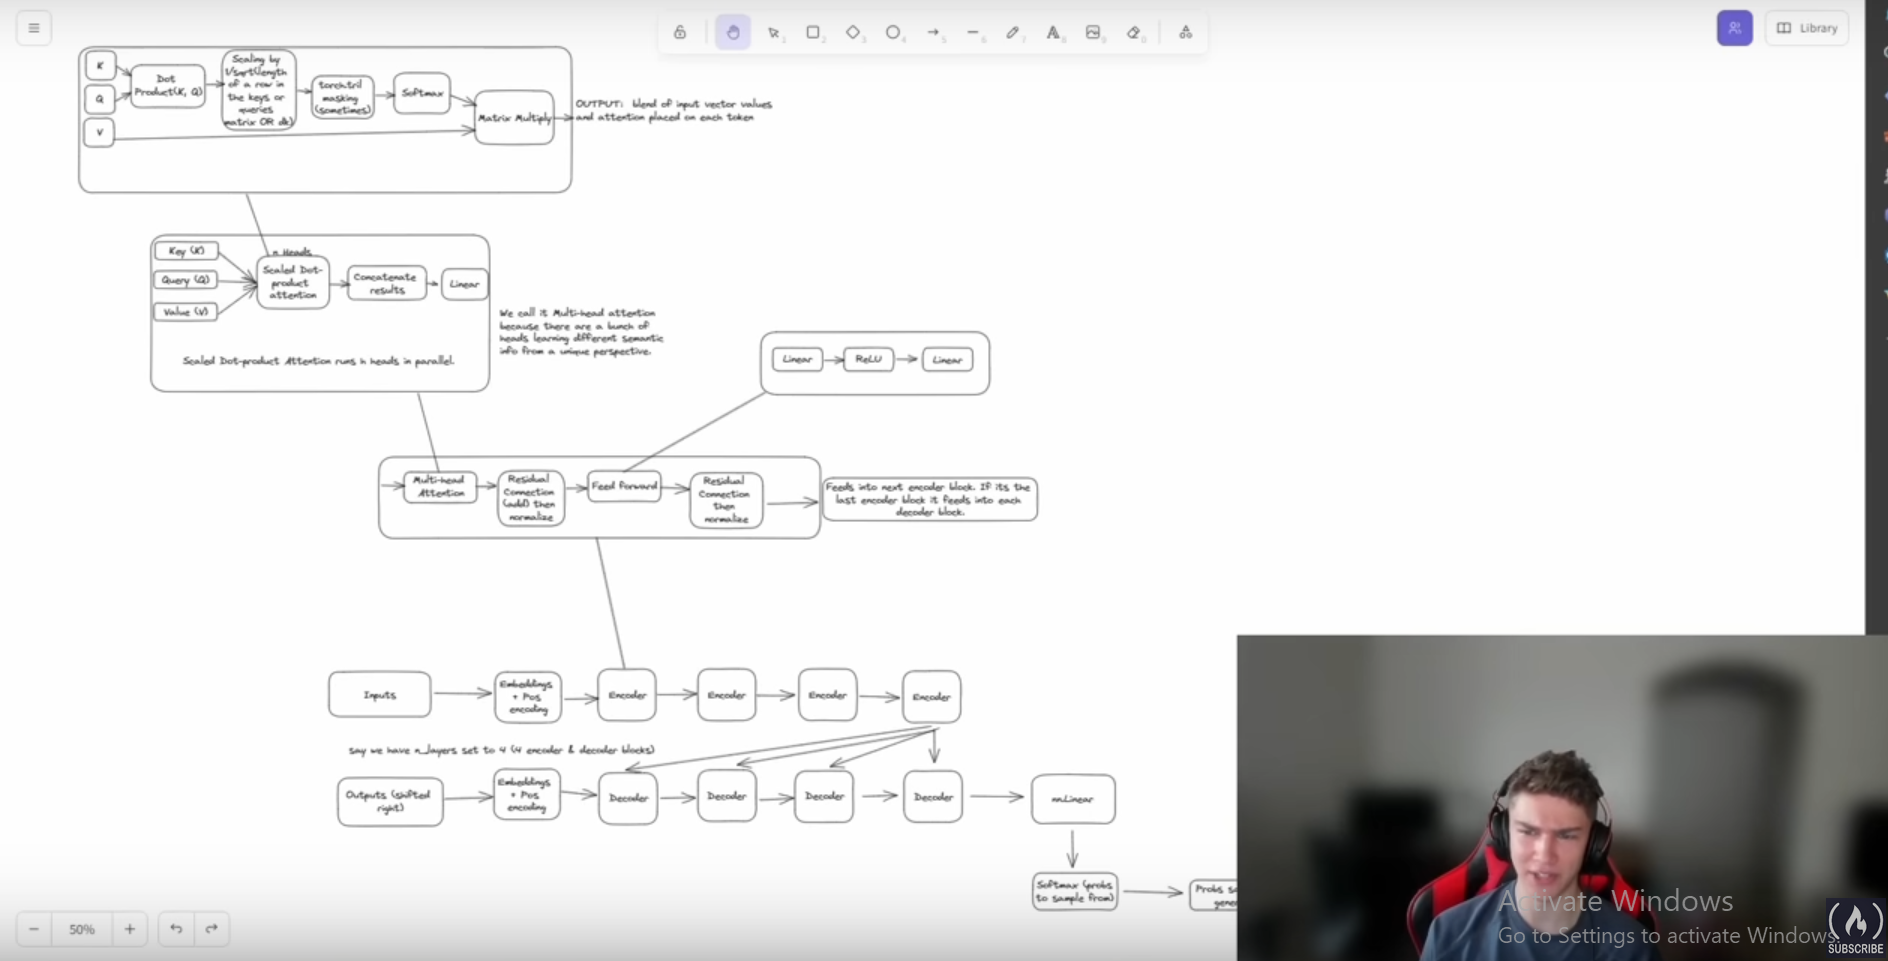

In [14]:
from IPython.display import Image
Image(filename='Transformer_in_nutshell.png',width=800, height=400)

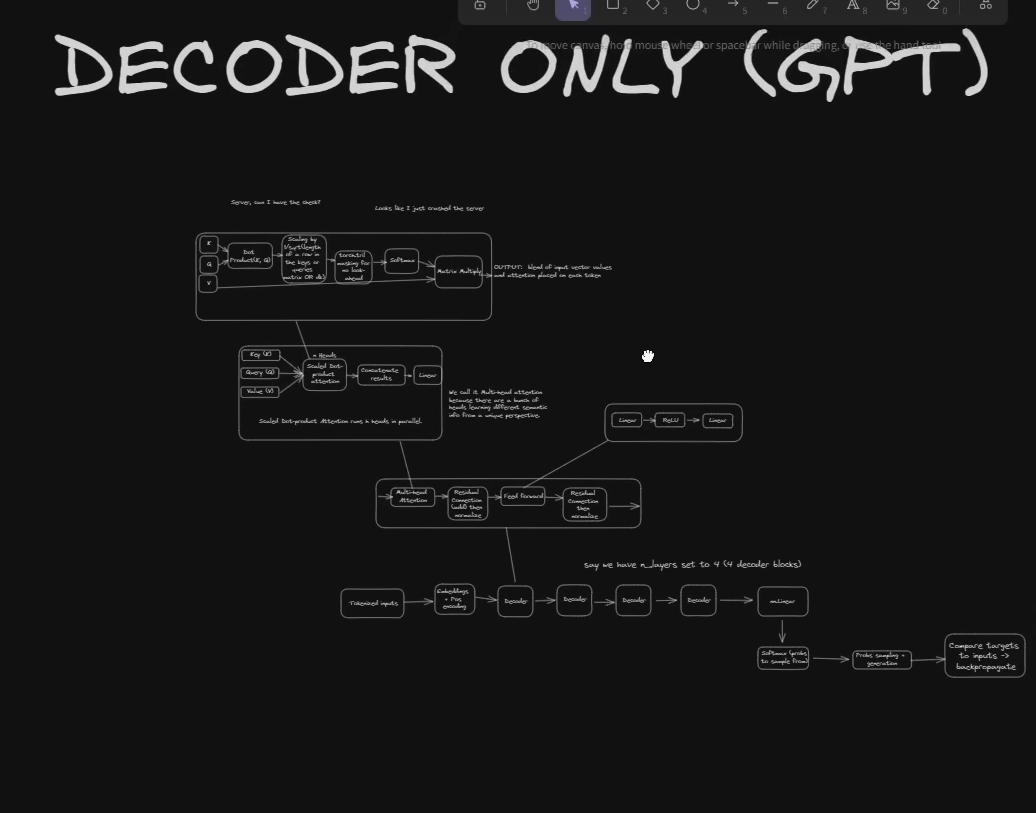

In [15]:
from IPython.display import Image
Image(filename='gpt_in_nutshell.png',width=800, height=400)

# GPT Model Definition

### Creating Estimate Loss

In [16]:
@torch.no_grad()# Disable GradientDescent
def estimate_loss(eval_iters):
    out = {}
    # Set Model to Evaluation Mode
    model.eval()
    for split in ['train','val']:
        # Create Tensor with length of 'eval_iters'
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            # Create dataset
            X, y = get_batch(split)
            # Extract logits and loss
            logits, loss = model.forward(X, y)
            # Stored loss on losses tensor
            losses[k] = loss.item()
        # Calculate the mean from the losses and stored to output
        out[split] = losses.mean()
    # Set Model to Train Mode
    model.train()
    return out

##### Notes

Use view to expand dimension of tensor

```py
torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size).shape
```

### Creating Head Class

In [17]:
class Head(nn.Module):
    """Transformer block: One head of self-attention"""
    """
    This is root of GPT Decoder
    
    Initialize key, query and value with nn.Linear(n_embd, head_size, bias=False)
    key = nn.Linear(n_embd, head_size, bias=False)
    query = nn.Linear(n_embd, head_size, bias=False)
    value = nn.Linear(n_embd, head_size, bias=False)
    
    (key, query, value) -> dot product(key @ query) -> scaling ((dot product)**1/sqrt(key or query size))-> masking with torch.tril to make sure data is not look ahead -> normalizing with soft max -> matrix multiply(normalized key and query * value)
    
    Masking are techique that hid real value from matrix
    
    suppose [1,2,4]
    
    the masking version would be
    
    [1,0,0]
    [1,2,0]
    [1,2,4]
    """
    def __init__(self, head_size):
        # Create key query value
        super().__init__()
        self.key = nn.Linear(n_embd,head_size,bias=False)
        self.query = nn.Linear(n_embd,head_size,bias=False)
        self.value = nn.Linear(n_embd,head_size,bias=False)
        
        # Confirm if scaler dot product attention is there
        self.flash = hasattr(F,'scaled_dot_product_attention')
        if not self.flash:
            # Register masking method named tril that contain torch.tril function (it can be called as self.tril on this class)
            self.register_buffer('tril',torch.tril(torch.ones(block_size, block_size)))
        # Drop 20% of neural network
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        #input of size (batch, time-step, channels)
        #output of size (batch, time-step, head size)
        batch_dim, time_dim, channel_dim = x.shape
        
        # Initializing key query value
        k = self.key(x) # (B, T, hs)
        q = self.query(x) # (B, T, hs)
        
        if self.flash:
            v = self.value(x)
            out = F.scaled_dot_product_attention(q,k,v,dropout_p=dropout)
        else:
            # Dot Product and Scaling
            #compute attention scores (affinities)
            wei = q @ k.transpose(-2,-1) * k.shape[-1] **-0.5
            
            # Masking
            wei = wei.masked_fill(self.tril[:time_dim,:time_dim] == 0, float('-inf')) # (B, T, T)
            
            # Normalizing with softmax
            wei = F.softmax(wei, dim=-1) # (B, T, T)
            wei = self.dropout(wei)
            
            # Perform the weighted aggregation of the values
            v = self.value(x) # (B, T, hs)
            out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

### Creating Multi Head Attention Class

In [18]:
class MultiHeadAttention(nn.Module):
    """Transformer block: Multi Head Attention Networks"""
    """
    (KEY, QUERY, VALUE) -> HEAD-> CONCAT RESULT-> LINEAR
    
    """
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # Creating torch module list contain Head Class so the head can running parralel
        
        # This add another parameter to multi head attention with input = n_embd and output = n_embd. the process will be:
        # Create multiple head each layer -> concatenate head each layer -> Linear -> Dropout 20% of neural network 
        self.proj = nn.Linear(head_size * num_heads, n_embd)# Projecting the head size (head_size * num_heads) to n_embd.
        self.dropout = nn.Dropout(dropout)# Drop 20% Neural Network 
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # Concatenate to -> (batch_dim, time_dim, feature_dim) -> (B, T, [h1, h1, h1, h1, h2, h2, h2, h2, h3, h3, h3, h3])
        out = self.dropout(self.proj(out))
        
        return out

### Creating Feed Forward Class

In [19]:
class FeedForward(nn.Module):
    """Transformer block: Feed Forward Networks"""
    """
    Process:
    nn.Linear-> nn.ReLu-> nn.Linear -> output
    """
    def __init__(self,n_embd):
        super().__init__()
        # Creating Deep Learning for Feed forward with sequential
        # Without nn.Sequential, the operation inside nn.Sequential will be put in forward for same effect(in other words, you define nn.Sequential manually in forward function)
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout),#Dropout Prevent Overfitting
        )
    
    def forward(self, x):        
        return self.net(x)

### Creating Decoder Block Class

In [20]:
class Block(nn.Module):
    """Transformer block: communication followed by computation"""
    """
    Process:
    MultiHeadAttention -> Residual Connection(add then normalize) -> Feed Forward (nn.Linear-> nn.ReLu-> nn.Linear) -> Residual Connection 2(add then normalize) -> output
    """
    
    def __init__(self, n_embd, n_head):
        # Get Parent properties
        super().__init__()
        head_size = n_embd // n_head # Get feature for each head to capture for MultiHeadAttention
        self.self_attention = MultiHeadAttention(n_head, head_size)# Create Self Attention with MultiHeadAttention
        self.ffwd = FeedForward(n_embd)# Use FeedForward to preprocessing after MultiHeadAttention based on GPT architecture (Linear, ReLu, Linear)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        y = self.self_attention(x)#MultiHeadAttention
        x = self.ln1(x+y)#Residual Connection(add then normalize)
        y = self.ffwd(x)#Feed Forward (nn.Linear-> nn.ReLu-> nn.Linear)
        x = self.ln2(x+y)#Residual Connection 2(add then normalize)
        return x #output
    

### Creating GPTLanguageModel Class

In [21]:
class GPTLanguageModel(nn.Module):# Create Neural Network with Gradient Descent for loss optimization
    def __init__(self, vocab_size):
        #Get Parent properties
        super().__init__()
        # Create Embbeded Layer 
        '''
        Embedded Layer being used for translating the character, text, etc by using vector to see how near or far the feature to target. the vector in Embedding torch are already being created on torch, so this function will only referencing the vector from pre-built embedding table.
        
        Embedding Table contain probability of character combination, like how 'bi' has 91039 occurence in million of data
        '''
        '''
        Position embedding table will be used with parameter (block_size, n_embd)
        and token embedding table will be used with parameter (vocab_size,n_emd)
        '''
        '''
        token embedding table are reference while position_embedding table are vector reference for distance between character per token.
        
        Example:
        there's text that has
        happy
        sad
        
        for happy, it has [0.9, 0.8] mean it's emotion section (0.8) and it's positive (0.9)
        
        for sad, it has [0.1, 0.8] mean it's emotion section (0.8) and it's negative (0.1)
        
        Sentimen analysis need two vector definition to define the section of words(token_embedding_table) and distance the words(position_embedding_table) to that section(token_embedding_table, position_embedding_table)
        
        parameter of nn.Embedding:
        - vocab_size = number of unique token, be it words variation('dodge','catch',etc.) to singular character('a','b','@',etc.)
        - n_embd = number of section it produce( imagin this array [0.9, 0.8] has length of n_embd long each vocab_size)
        
        Why using nn.embedding over fixed function for position embedding
        '''
        self.token_embedding_table = nn.Embedding(vocab_size,n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        
        # Initialize how many decoder that neeed to be initialize
        '''The asterisk (*) is used to unpack the elements of the list comprehension into the nn.Sequential constructor. This is a common usage in Python, and it's known as the "unpacking" or "splat" operator.
        
        self blocks will creating 4 layer decoder'''
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        
        # Initialize final Normalizer before being pushed to nn.Linear()
        self.ln_f = nn.LayerNorm(n_embd)
        
        # Summarized the neural network to nn.Linear()
        '''
        Linear Parameter Explained:
        nn.Linear(in_features, out_features, bias=True)

        in_features: This parameter specifies the number of input features to the linear layer. It represents the size of the input tensor that will be transformed by the linear layer. In the context of neural networks, this is typically the number of neurons in the preceding layer or the number of input dimensions.

        out_features: This parameter specifies the number of output features or neurons produced by the linear layer. It determines the size of the output tensor. In the context of neural networks, this represents the number of neurons in the current layer.

        bias: This is a boolean parameter that indicates whether the linear layer includes a bias term. If set to True, the linear transformation includes a learnable bias term. If set to False, the linear transformation is applied without the bias term. The bias term allows the linear layer to shift the output in a way that is independent of the input data.
        '''
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        # Apply Weight
        self.apply(self._init_weights)
    
        '''
         Weight initialization strategy is common in deep learning to ensure that the initial weights are suitable  for training the model. The chosen mean and standard deviation values are empirical and are often used as    good starting points in practice. The goal is to provide a reasonable initialization that helps the model  converge during training.
        '''
    def _init_weights(self,module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight,mean=0.0, std=0.02)
        '''
        Explanation of Why mean and std value are like that:

    Weight Initialization Strategies:
        Proper weight initialization is crucial for training neural networks effectively. The chosen values aim to strike a balance between preventing vanishing/exploding gradients and promoting stable learning during training.

    Empirical Values:
        The values, such as mean=0.0 and std=0.02, are often chosen empirically based on experimental observations and best practices.
        These specific values are commonly used in the initialization of neural network weights, and they work well in practice for a variety of architectures.

    Normalization:
        Normalizing the weights around zero with a small standard deviation helps prevent the gradients from becoming too large or too small during backpropagation.

    Consistency Across Layers:
        Consistent weight initialization across layers can help maintain a stable learning process throughout the network.

    Adaptation to Activation Functions:
        The values are chosen to adapt well to activation functions commonly used in deep learning models.
        
        In Summary, mean=0 mean the data centered around zero and std=0.02 are data have difference in each variance around 0.02 long.
        '''
    
    # Forward Function
    def forward(self,index,target=None):
        batch_dim,time_dim = index.shape
        
        #index and target are both batch_dim,time_dim(B,T) tensor of integers
        tok_emb = self.token_embedding_table(index)# batch_dim,time_dim,channel_dim(B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(time_dim, device=device))# (T, C)
        x = tok_emb + pos_emb #(B, T, C)
        x = self.blocks(x) #(B, T, C)
        x = self.ln_f(x) #(B, T, C)
        logits = self.lm_head(x) #(B, T, vocab_size)
        
        if target is None:
            loss = None
        else:
            batch_dim,time_dim, channel_dim = logits.shape
            # Reshape for cross entropy evaluation
            logits = logits.view(batch_dim*time_dim,channel_dim)
            target = target.view(batch_dim*time_dim)
            loss = F.cross_entropy(logits,target)
        
        return logits, loss
    
    # Generate Function
    def generate(self,index,max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

# Model Definition

In [22]:
model = GPTLanguageModel(vocab_size=vocab_size)
m = model.to(device)

# Training Model

In [23]:
%%time
# Initialize Optimizer
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
# Train The model
for iter in range(max_iters):
    if iter % eval_iters == 0:
        losses = estimate_loss(eval_iters)
        print(f"""step:{iter}, loss train:{losses["train"]:.4f}, loss val:{losses["val"]:.4f}""")
        
    # sample a batch of data
    xb, yb = get_batch('train')
    
    # Evaluate the loss
    logits, loss = model.forward(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

step:0, loss train:10.4644, loss val:10.4497
step:250, loss train:0.7110, loss val:0.7380
step:500, loss train:0.4209, loss val:0.3809
step:750, loss train:0.3448, loss val:0.3470
step:1000, loss train:0.3266, loss val:0.2948
step:1250, loss train:0.3494, loss val:0.3842
step:1500, loss train:0.3099, loss val:0.2934
step:1750, loss train:0.3018, loss val:0.2699
step:2000, loss train:0.2710, loss val:0.2694
step:2250, loss train:0.2586, loss val:0.2759
step:2500, loss train:0.2846, loss val:0.3090
step:2750, loss train:0.4385, loss val:0.4417
step:3000, loss train:0.3793, loss val:0.3211
step:3250, loss train:0.2968, loss val:0.3260
step:3500, loss train:0.3044, loss val:0.3361
step:3750, loss train:0.4821, loss val:0.4518
step:4000, loss train:0.2971, loss val:0.2881
step:4250, loss train:0.2848, loss val:0.2906
step:4500, loss train:0.2856, loss val:0.2864
step:4750, loss train:0.2623, loss val:0.2605
step:5000, loss train:0.2554, loss val:0.2516
step:5250, loss train:0.2907, loss val

In [24]:
with open('model.pkl','wb') as f:
    import pickle
    pickle.dump(model,f)

In [25]:
with open('model.pkl','rb') as f:
    import pickle
    god = pickle.load(f)

context = torch.tensor(encode('こんにちは'), dtype=torch.long, device=device)
generated_chars = decode(god.generate(context.unsqueeze(0),max_new_tokens=100)[0].tolist())
print(generated_chars)

こんにちは p  pompuis tole th Mheng   IW al me  u in hine an s weed kor courut py ot ponsech mew. ivohon. she 


In [26]:
%%time
optimizer = torch.optim.AdamW(god.parameters(),lr=learning_rate)
# Train The god
for iter in range(max_iters):
    if iter % eval_iters == 0:
        losses = estimate_loss(eval_iters)
        print(f"""step:{iter}, loss train:{losses["train"]:.4f}, loss val:{losses["val"]:.4f}""")
        
    # sample a batch of data
    xb, yb = get_batch('train')
    
    # Evaluate the loss
    logits, loss = god.forward(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

step:0, loss train:0.2817, loss val:0.3109
step:250, loss train:0.3453, loss val:0.2934
step:500, loss train:0.2936, loss val:0.3164
step:750, loss train:0.3400, loss val:0.2917
step:1000, loss train:0.3636, loss val:0.2810
step:1250, loss train:0.3070, loss val:0.2924
step:1500, loss train:0.3347, loss val:0.3016
step:1750, loss train:0.3620, loss val:0.2973
step:2000, loss train:0.2880, loss val:0.2848
step:2250, loss train:0.3435, loss val:0.3247
step:2500, loss train:0.3027, loss val:0.3073
step:2750, loss train:0.2998, loss val:0.2876
step:3000, loss train:0.3142, loss val:0.3101
step:3250, loss train:0.2812, loss val:0.3703
step:3500, loss train:0.3161, loss val:0.3050
step:3750, loss train:0.3679, loss val:0.3010
step:4000, loss train:0.3180, loss val:0.4213
step:4250, loss train:0.3003, loss val:0.3046
step:4500, loss train:0.2860, loss val:0.3145
step:4750, loss train:0.3137, loss val:0.3060
step:5000, loss train:0.2963, loss val:0.2911
step:5250, loss train:0.3013, loss val:0

In [28]:
import joblib
md = joblib.load('model.pkl')
context = torch.tensor(encode('Hello?'), dtype=torch.long, device=device)
generated_chars = decode(md.generate(context.unsqueeze(0),max_new_tokens=100)[0].tolist())
print(generated_chars)

Hello?lll? irayysco suckellensuas re gaililt tinntfs akeftty bated at s catyethennceniieg,"
)
 medy it hy 
